In [1]:
import sys
sys.path.insert(0, "../..")

In [7]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import Experiment, RestartingExperiment

In [3]:
device = "cpu"

X = []
with open("../../../madelon_train.data") as f:
    for line in f:
        X.append([float(x) for x in line.split()])
X = np.array(X)
X /= X.max()
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X = torch.tensor(X, device=device)
with open("../../../madelon_train.labels") as f:
    y = [int(x) for x in f]
y = torch.tensor(y, device=device)
X.shape, y.shape

(torch.Size([2000, 501]), torch.Size([2000]))

In [4]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## $\tau = 10^{-3}$

In [8]:
model = LogisticRegressionGD(X_train, y_train, 1e-3, device=device)

In [9]:
model.fit(1e-8, max_iter=100500)

In [10]:
len(model.log)

100501

In [11]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.5600, dtype=torch.float64)

### Without restarting

In [12]:
experiment = Experiment(model.log, model.obj, values=model.value_log)
k = 6

In [13]:
experiment.run_method("VLT", levin_transform, k+1, method_kwargs={"k": k, "type": "t"})

In [14]:
experiment.run_method("VLU", levin_transform, k+1, method_kwargs={"k": k, "type": "u"})

In [15]:
experiment.run_method("VLV", levin_transform, k+2, method_kwargs={"k": k, "type": "v"})

In [16]:
experiment.run_method("RRE+QR", RRE, k, method_kwargs={"qr": True})

In [17]:
n = k+1
p = 7
m = np.arange(n)[None, :] + 1 + (p - 1) * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [18]:
experiment.run_method("VJT", j_algorithm, k+1, method_kwargs={"deltas": deltas, "type": "t"})

In [19]:
experiment.run_method("VJU", j_algorithm, k+1, method_kwargs={"deltas": deltas, "type": "u"})

In [20]:
n = k+2
p = 7
m = np.arange(n)[None, :] + 1 + (p - 1) * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [21]:
experiment.run_method("VJV", j_algorithm, k+2, method_kwargs={"deltas": deltas, "type": "v"})

In [22]:
n = k+1
m = np.arange(n)[None, :] + 1 + 2 * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [23]:
experiment.run_method("VST", j_algorithm, k+1, method_kwargs={"deltas": deltas, "type": "t"})

In [24]:
experiment.run_method("VSU", j_algorithm, k+1, method_kwargs={"deltas": deltas, "type": "u"})

In [25]:
n = k+2
m = np.arange(n)[None, :] + 1 + 2 * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [26]:
experiment.run_method("VSV", j_algorithm, k+2, method_kwargs={"deltas": deltas, "type": "v"})

In [27]:
l = k//2
n = k+1
alpha = 0.5
delta_l = np.ones((l, n)) + np.arange(l)[:, None]
deltas = np.zeros((k, n), dtype=np.complex)
deltas[::2] = np.exp(2j * alpha * np.arange(n)[None, :])
deltas[1::2] = np.exp(-2j * alpha * np.arange(n)[None, :]) * delta_l
deltas = np.real(deltas)

In [28]:
experiment.run_method("VIT", j_algorithm, k+1, method_kwargs={"deltas": deltas, "type": "t"})

In [29]:
experiment.run_method("VIU", j_algorithm, k+1, method_kwargs={"deltas": deltas, "type": "u"})

In [30]:
l = k//2
n = k+2
alpha = 0.5
delta_l = np.ones((l, n)) + np.arange(l)[:, None]
deltas = np.zeros((k, n), dtype=np.complex)
deltas[::2] = np.exp(2j * alpha * np.arange(n)[None, :])
deltas[1::2] = np.exp(-2j * alpha * np.arange(n)[None, :]) * delta_l
deltas = np.real(deltas)

In [31]:
experiment.run_method("VIV", j_algorithm, k+2, method_kwargs={"deltas": deltas, "type": "v"})

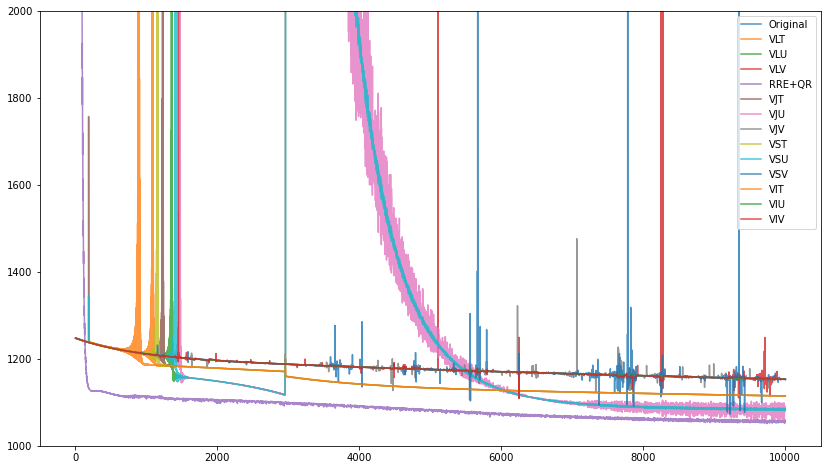

In [32]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000)
plt.ylim(1000, 2000)
plt.legend()

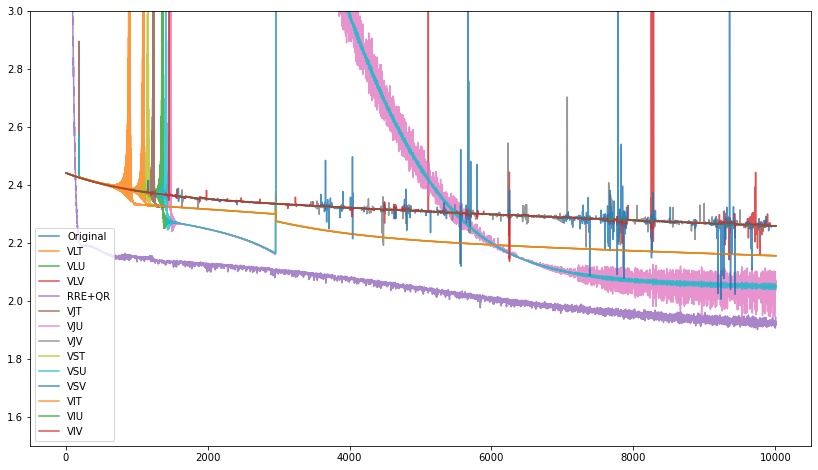

In [33]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000)
plt.ylim(1.5, 3)
plt.legend()

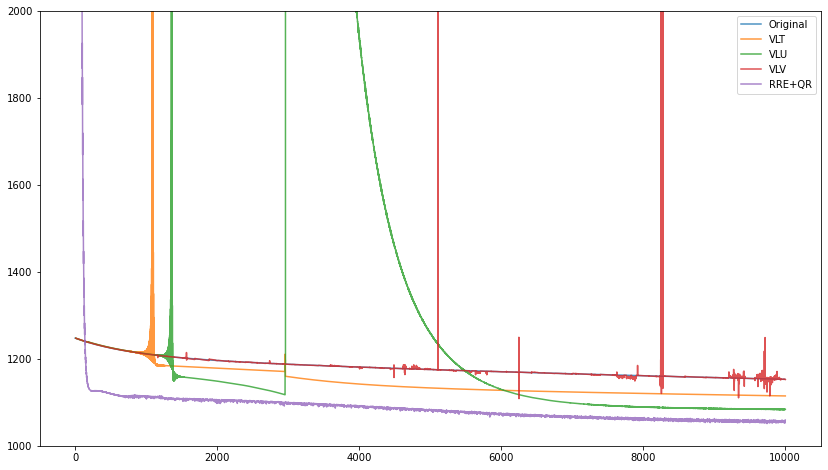

In [34]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VLT", "VLU", "VLV", "RRE+QR"])
plt.ylim(1000, 2000)
plt.legend()

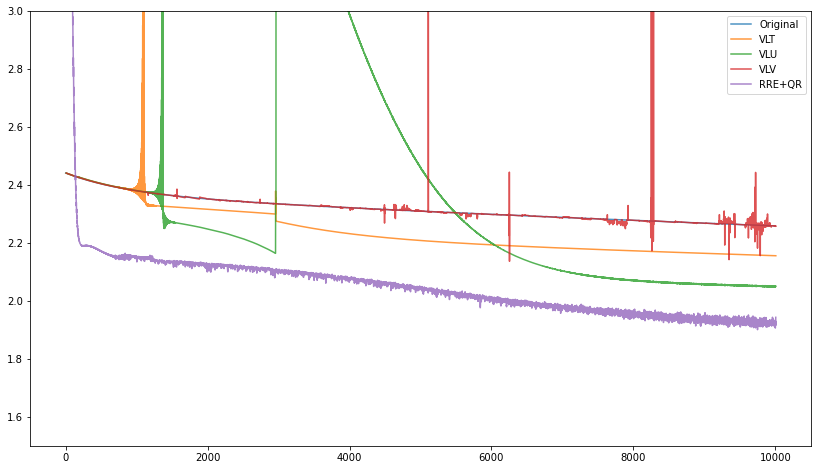

In [35]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VLT", "VLU", "VLV", "RRE+QR"])
plt.ylim(1.5, 3)
plt.legend()

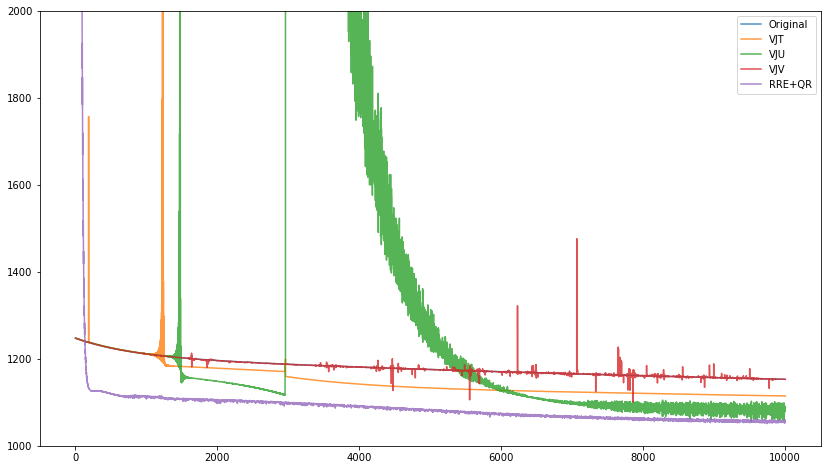

In [36]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VJT", "VJU", "VJV", "RRE+QR"])
plt.ylim(1000, 2000)
plt.legend()

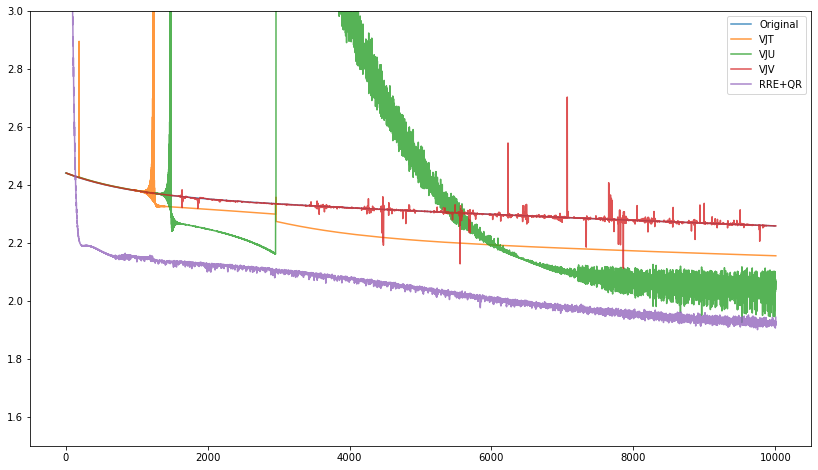

In [37]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VJT", "VJU", "VJV", "RRE+QR"])
plt.ylim(1.5, 3)
plt.legend()

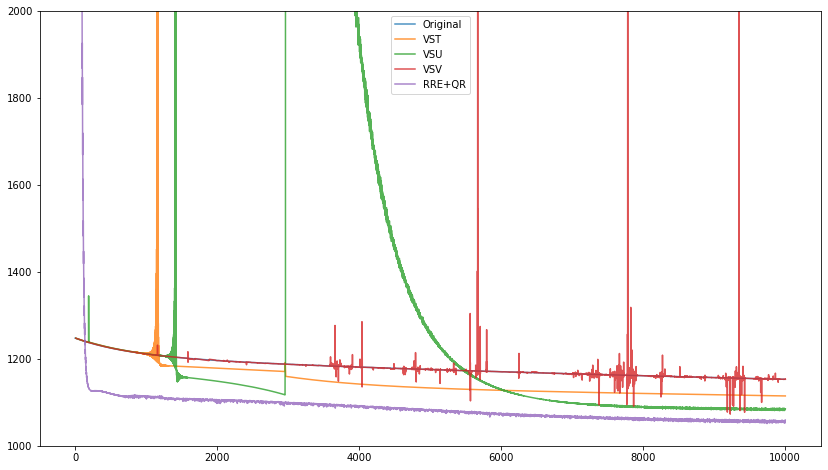

In [38]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VST", "VSU", "VSV", "RRE+QR"])
plt.ylim(1000, 2000)
plt.legend()

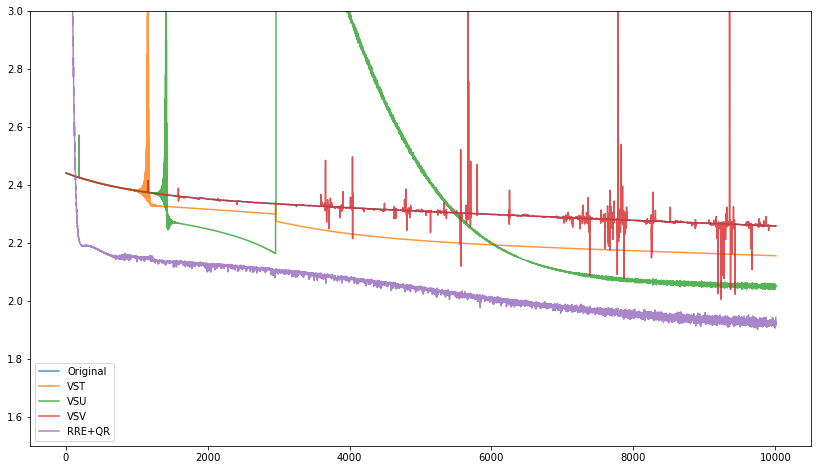

In [39]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VST", "VSU", "VSV", "RRE+QR"])
plt.ylim(1.5, 3)
plt.legend()

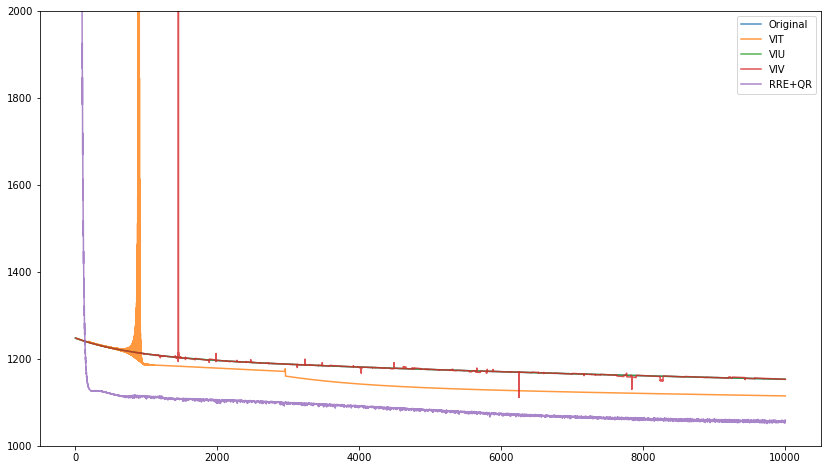

In [40]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VIT", "VIU", "VIV", "RRE+QR"])
plt.ylim(1000, 2000)
plt.legend()

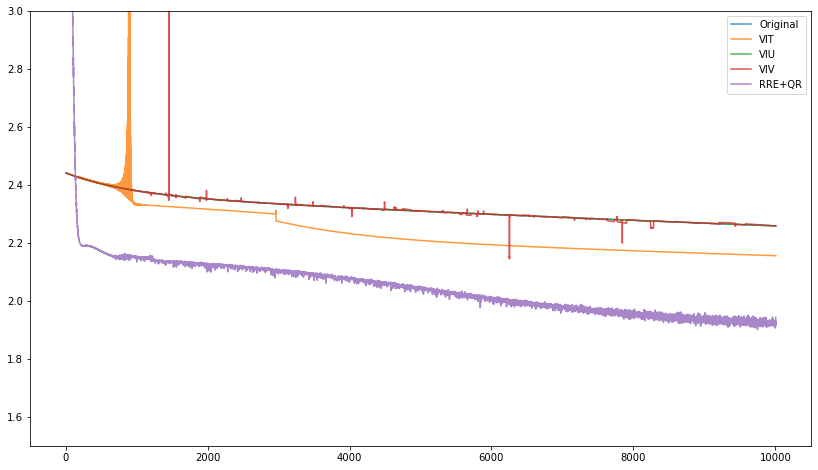

In [41]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VIT", "VIU", "VIV", "RRE+QR"])
plt.ylim(1.5, 3)
plt.legend()

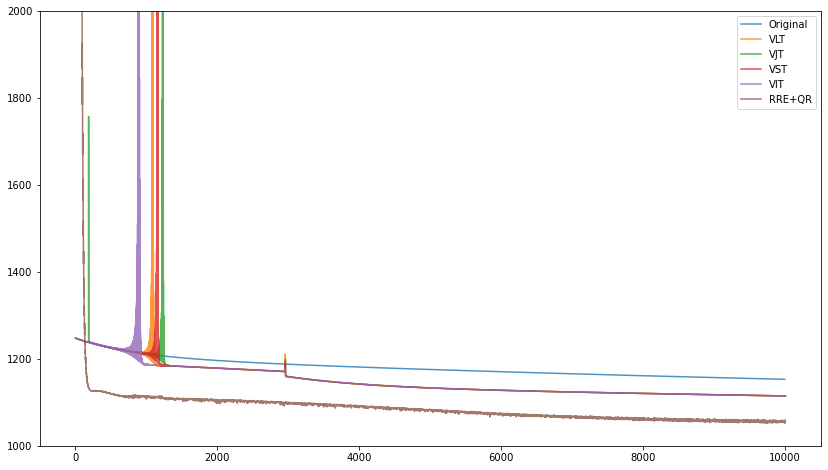

In [43]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VLT", "VJT", "VST", "VIT", "RRE+QR"])
plt.ylim(1000, 2000)
plt.legend()

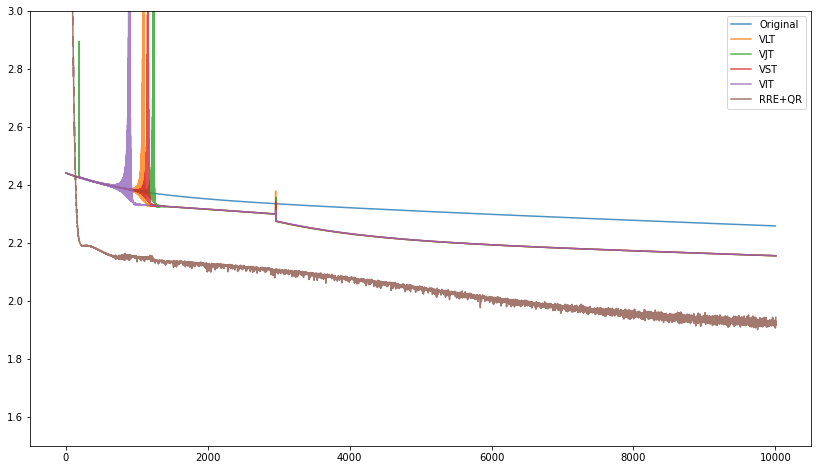

In [44]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VLT", "VJT", "VST", "VIT", "RRE+QR"])
plt.ylim(1.5, 3)
plt.legend()

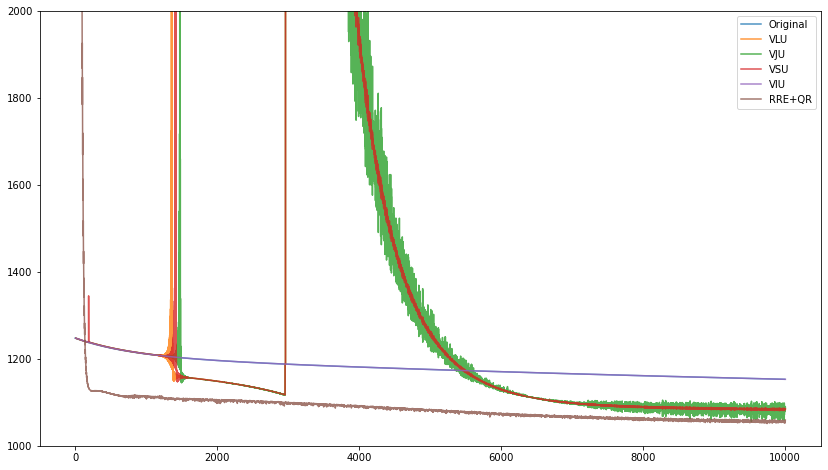

In [46]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VLU", "VJU", "VSU", "VIU", "RRE+QR"])
plt.ylim(1000, 2000)
plt.legend()

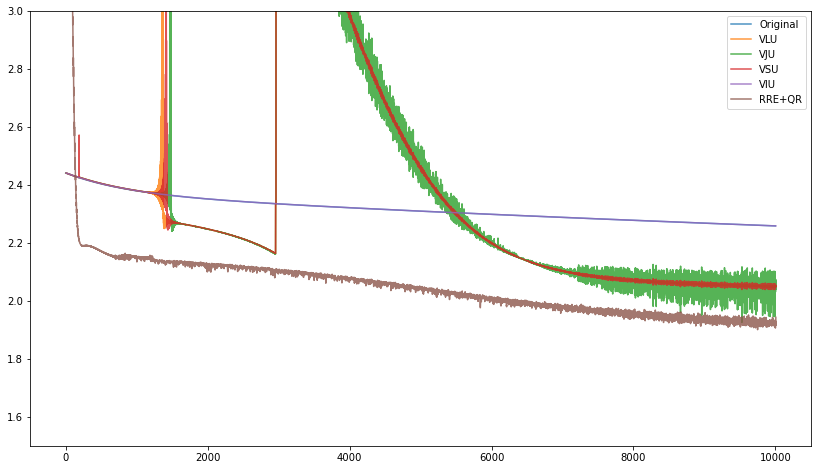

In [47]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VLU", "VJU", "VSU", "VIU", "RRE+QR"])
plt.ylim(1.5, 3)
plt.legend()

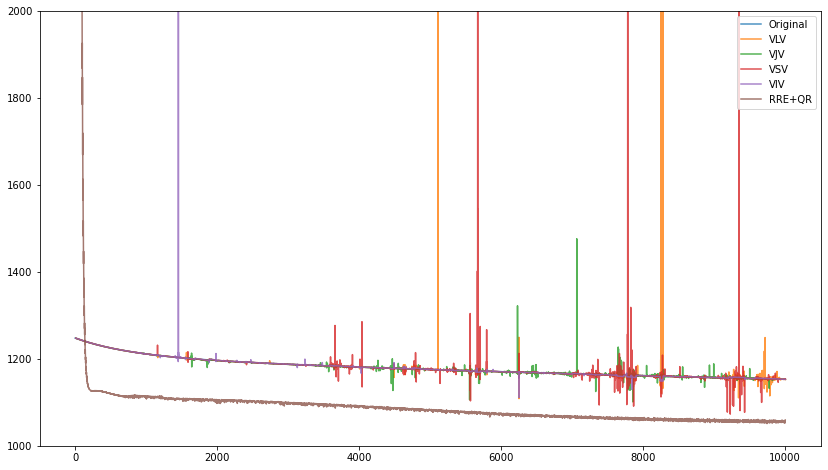

In [48]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VLV", "VJV", "VSV", "VIV", "RRE+QR"])
plt.ylim(1000, 2000)
plt.legend()

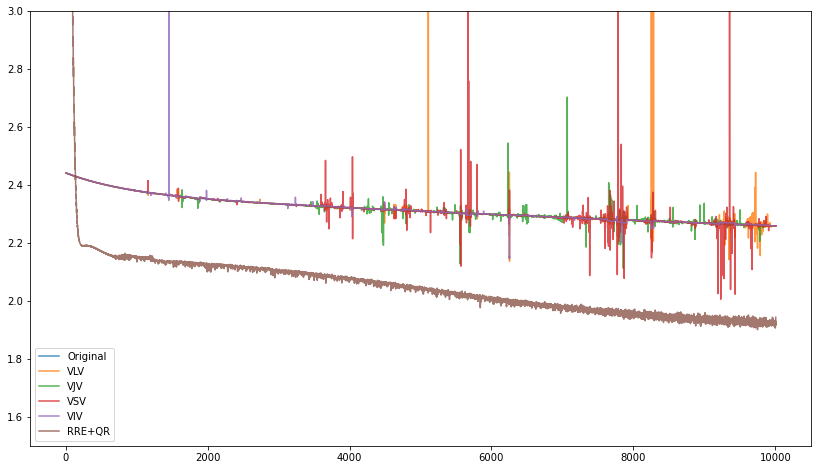

In [49]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VLV", "VJV", "VSV", "VIV", "RRE+QR"])
plt.ylim(1.5, 3)
plt.legend()

In [50]:
model.theta = experiment.best_x
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.5450, dtype=torch.float64)

In [42]:
df = experiment.value_df()
df.to_csv("results/madelon_levin_type:tau=1e-3.csv")